<a href="https://colab.research.google.com/github/hknaini/maskdtectionretinanet/blob/master/RetinaNetMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5893 (delta 3), reused 0 (delta 0), pack-reused 5885
Receiving objects: 100% (5893/5893), 13.41 MiB | 34.60 MiB/s, done.
Resolving deltas: 100% (3967/3967), done.


In [2]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170849 sha256=4215dcfbe64cd5ed08c69580e3c02b9199b54072bd23514cb4fd10a09d8e3e59
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=acb536486aa0c74fcded6cd763ec4f9846fb19592bb2511fba4617184a99505d
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [4]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import sys, os
from glob import glob

In [6]:
import cv2

In [7]:
base = Path('/content/drive/My Drive/ColabData/')
sys.path.append(str(base))

In [8]:
zip_path = base/'HKMaskImages.zip'
print(zip_path)
!cp '{zip_path}' .
!unzip -q HKMaskImages.zip
!rm HKMaskImages.zip

/content/drive/My Drive/ColabData/HKMaskImages.zip


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

In [11]:
import json
#j = json.loads(open('AllAnnotations.json').readline())
df = pd.read_json('AllAnnotations.json', lines=True)

In [ ]:
dfnp = df.to_numpy()

In [12]:
df.head(1)

,annotation
0,"{'folder': 'images', 'filename': 'maksssksksss..."


In [13]:
converted_data_train = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

converted_data_test = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

In [14]:
df.head(1)["annotation"]

0    {'folder': 'images', 'filename': 'maksssksksss...
Name: annotation, dtype: object

In [15]:
idx = 0 # global counter for filenames

def map_to_data(row, converted_data):
  global idx
  
  # there could be more than 1 face per image
  for obj in row['annotation']['object']:
      #print("img"+str(idx))
    
      converted_data['image_name'].append('HKMaskImages/'+row['annotation']['filename'])
      
      # calculate box coordinates
      
      x1 = int((obj['bndbox'].get('xmin')))
      y1 = int((obj['bndbox'].get('ymin')))
      x2 = int((obj['bndbox'].get('xmax')))
      y2 = int((obj['bndbox'].get('ymax')))

      converted_data['x_min'].append(x1)
      converted_data['y_min'].append(y1)
      converted_data['x_max'].append(x2)
      converted_data['y_max'].append(y2)

      # they are all the same class
      converted_data['class_name'].append(obj['name'])
   
  # update counter
  idx += 1

In [16]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [ ]:
train_df.iloc[0]

annotation    {'folder': 'images', 'filename': 'maksssksksss...
Name: 151, dtype: object

In [ ]:
map_to_data(df.iloc[235], converted_data_train)

img0
img0


In [17]:
train_df.apply(lambda row: map_to_data(row, converted_data_train), axis=1)

355    None
267    None
236    None
380    None
395    None
       ... 
320    None
227    None
64     None
230    None
316    None
Length: 320, dtype: object

In [18]:
test_df.apply(lambda row: map_to_data(row, converted_data_test), axis=1)

327    None
136    None
156    None
396    None
223    None
       ... 
51     None
262    None
388    None
309    None
95     None
Length: 80, dtype: object

In [19]:
print(len(converted_data_test['class_name']))
print(len(converted_data_test['image_name']))
print((converted_data_train['image_name'][5]))
print(len(converted_data_test['x_min']))
print(len(converted_data_test['y_min']))

398
398
HKMaskImages/maksssksksss339.png
398
398


In [20]:
# this will overwrite the previous dfs
train_df = pd.DataFrame(converted_data_train)
test_df = pd.DataFrame(converted_data_test)

In [ ]:
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,HKMaskImages/maksssksksss374.png,183,21,215,51,with_mask
1,HKMaskImages/maksssksksss374.png,28,91,52,113,with_mask
2,HKMaskImages/maksssksksss374.png,191,143,225,182,with_mask
3,HKMaskImages/maksssksksss374.png,314,30,345,61,without_mask
4,HKMaskImages/maksssksksss374.png,92,64,123,89,with_mask


In [ ]:
from google.colab.patches import cv2_imshow

In [47]:
def show_image_with_boxes(df):
  # pick a random image
  filepath = df.sample()['image_name'].values[0] #'HKMaskImages/maksssksksss324.png'
  #df.sample()['image_name'].values[0]
  print(filepath)

  # get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))

  # if there's a PNG it will have alpha channel
  #im = im[:,:,:3]

  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    #draw_box(im, box, color=(255, 0, 0))
    b = np.array(box).astype(int)
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), color=(0, 255, 0, 255), thickness=2)

  #plt.axis('off')
  #cv2_imshow(im)
  plt.imshow(im)
  print(im.shape)
  plt.show()

HKMaskImages/maksssksksss280.png
[25, 54, 43, 72]
[69, 25, 82, 38]
[94, 68, 111, 84]
[142, 18, 155, 30]
[158, 31, 174, 48]
[197, 84, 218, 107]
[175, 15, 190, 30]
[201, 18, 215, 32]
[239, 62, 257, 81]
[236, 49, 250, 63]
[164, 17, 174, 25]
[233, 22, 242, 33]
[235, 7, 245, 16]
[260, 31, 273, 42]
[247, 2, 257, 12]
[274, 15, 284, 27]
[294, 9, 306, 22]
[305, 12, 310, 21]
[287, 10, 295, 19]
[347, 11, 359, 21]
[376, 21, 388, 33]
(267, 400, 4)


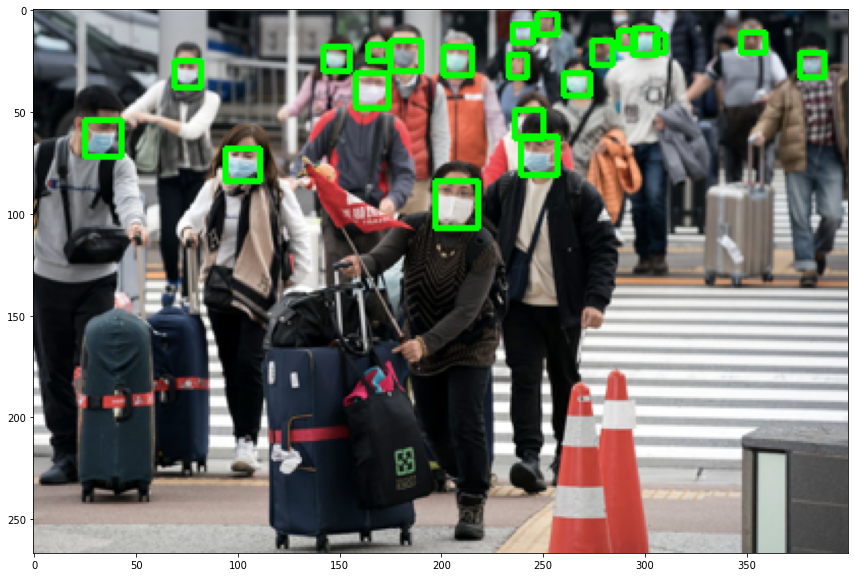

In [49]:
show_image_with_boxes(train_df)

In [30]:
train_df.to_csv('annotations.csv', index=False, header=None)

In [31]:
classes = ['with_mask','without_mask','mask_weared_incorrect']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')

In [32]:
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

In [33]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to snapshots/_pretrained_model.h5


In [ ]:
!ls keras-retinanet/keras_retinanet/bin

ls: cannot access 'keras-retinanet/keras_retinanet/bin': No such file or directory


In [ ]:
%cd keras_retinanet

/content/keras-retinanet/keras_retinanet


In [ ]:
!ls keras_retinanet	losses.py

backend  callbacks	  __init__.py  losses.py  preprocessing  utils
bin	 initializers.py  layers       models	  __pycache__


In [ ]:
%cd bin

/content/keras-retinanet/keras_retinanet/bin


In [ ]:
!ls
%cd ..

/


In [ ]:
%cd ..

/content/keras-retinanet


In [ ]:
!keras_retinanet/bin/train.py --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 8 \
  --steps 200 \
  --epochs 15 \
  csv annotations.csv classes.csv

In [35]:
from glob import glob
model_paths = glob('snapshots/resnet50_csv_*.h5')
latest_path = sorted(model_paths)[-1]
print("path:", latest_path)

model = models.load_model(latest_path, backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

path: snapshots/resnet50_csv_15.h5


Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [67]:
from io import BytesIO

def convertToJpeg(im):
    with BytesIO() as f:
        im.save(f, format='JPEG')
        return f.getvalue()

In [71]:
!ls

AllAnnotations.json  CONTRIBUTORS.md  keras_retinanet	setup.cfg
annotations.csv      examples	      LICENSE		setup.py
build		     HKMaskImages     README.md		snapshots
classes.csv	     images	      requirements.txt	tests


In [93]:
def show_image_with_predictions(df, threshold=0.6):
  # choose a random image
  row = df.sample()
  filepath = row['image_name'].values[0]
  #'HKMaskImages/maksssksksss238.png' 
  print("filepath:", filepath)

  # get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  #im = im[:,:,:3]
  #im = convertToJpeg(im)
  cv2.imwrite('image.jpg', im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
  im = image = cv2.imread('image.jpg')
  # plot true boxes
  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    b = np.array(box).astype(int)
    #cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), color=(0, 255, 0,255), thickness=2)
    #draw_box(im, box, color=(255, 0, 0))
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im, mode='tf')
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )

  # standardize box coordinates
  boxes /= scale

  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    #print(box)
    color = label_color(label)
    b = np.array(box).astype(int)
    cv2.rectangle(im, (b[0], b[1]), (b[2], b[3]), color=(0, 255, 0), thickness=2)
    #draw_box(im, box, color=color)

    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    print(caption)
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


In [95]:
#plt.rcParams['figure.figsize'] = [20, 10]

In [ ]:
show_image_with_boxes(test_df)

filepath: HKMaskImages/maksssksksss1.png
im.shape: (156, 400, 4)
[321, 34, 354, 69]
[224, 38, 261, 73]
[299, 58, 315, 81]
[143, 74, 174, 115]
[74, 69, 95, 99]
[191, 67, 221, 93]
[21, 73, 44, 93]
[369, 70, 398, 99]
[83, 56, 111, 89]
with_mask 0.664
with_mask 0.645
with_mask 0.578
without_mask 0.537
with_mask 0.512
with_mask 0.503
with_mask 0.379
with_mask 0.352
with_mask 0.343
without_mask 0.327


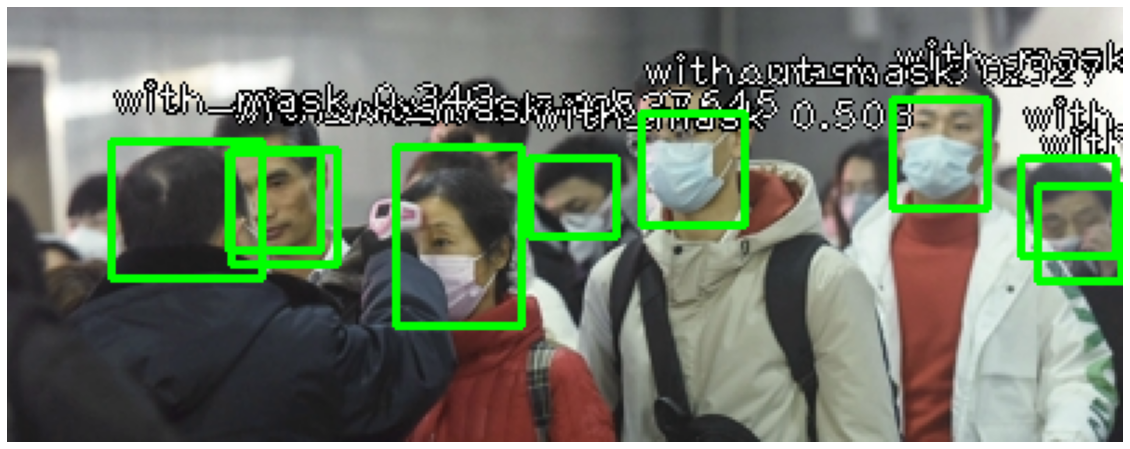

In [96]:
show_image_with_predictions(test_df, threshold=0.3)